In [62]:
# !pip install sagemaker ipywidgets --upgrade --quiet

In [63]:
# import sagemaker, boto3, json
# from sagemaker.session import Session

# sagemaker_session = Session()
# aws_role = sagemaker_session.get_caller_identity_arn()
# aws_region = boto3.Session().region_name
# sess = sagemaker.Session()

In [ ]:
# s3_bucket = "<BUCKET ID HERE>"
# s3 = boto3.client("s3")
# s3.download_file(s3_bucket, "TestValTrain/val.tfrecord.gz", "val.tfrecord.gz")
# s3.download_file(s3_bucket, "TestValTrain/test.tfrecord.gz", "test.tfrecord.gz")

In [ ]:
import time
import sys
import os
import glob
import math
import threading
import concurrent.futures as cf
import random
import re

import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Input, Model, layers, metrics, losses, callbacks, optimizers, models, utils
from keras import backend as K
import gc
import keras_tuner as kt
from pyfaidx import Fasta

K.clear_session()
gc.collect()

datasets_path = "../../Datasets/"
models_path = "../../Models/"

0

In [66]:
@utils.register_keras_serializable()
class CustomNoBackgroundF1Score(metrics.Metric):
    def __init__(self, num_classes, average='weighted', threshold=0.5, name='no_background_f1', **kwargs):
        """
        Custom F1 score metric that only considers non-dominant classes (ignoring index 0).
        
        This version is designed for multi-encoded labels where:
          - The dominant class (index 0) is represented as a hard label [1, 0, 0, ...]
          - For non-dominant classes (indices 1 to num_classes-1), only an exact label of 1 is considered positive.
            (Any partial credit/smoothed values below 1 are treated as 0.)
          - Predictions are thresholded (default threshold = 0.5) to decide 1 vs. 0.
        
        Args:
            num_classes (int): Total number of classes.
            average (str): 'weighted' (default) to weight by support or 'macro' for a simple average.
            threshold (float): Threshold on y_pred to decide a positive (default 0.5).
            name (str): Name of the metric.
            **kwargs: Additional keyword arguments.
        """
        super(CustomNoBackgroundF1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        if average not in ['weighted', 'macro']:
            raise ValueError("average must be 'weighted' or 'macro'")
        self.average = average

        # Create state variables to accumulate counts for each class.
        # We use a vector of length num_classes but we will update only indices 1...num_classes-1.
        self.true_positives = self.add_weight(
            name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )
        self.false_positives = self.add_weight(
            name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )
        self.false_negatives = self.add_weight(
            name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the metric state.
        
        Args:
            y_true: Tensor of shape (batch_size, num_classes). These are multi-encoded labels.
                    For non-dominant classes, a label is considered positive only if it is exactly 1.
            y_pred: Tensor of shape (batch_size, num_classes) with predictions (e.g. probabilities).
            sample_weight: Optional sample weights.
        """
        
        # Flatten all dimensions except the last one (which should be num_classes).
        y_true = tf.reshape(y_true, [-1, self.num_classes])
        y_pred = tf.reshape(y_pred, [-1, self.num_classes])
        
        # We want to ignore the dominant class (index 0) and work on classes 1...num_classes-1.
        # Assume y_true and y_pred are both of shape (batch_size, num_classes).
        y_true_non_dominant = y_true[:, 1:]
        y_pred_non_dominant = y_pred[:, 1:]
        
        # For ground truth: treat a class as positive only if its value is exactly 1.
        one_value = tf.cast(1.0, dtype=y_true_non_dominant.dtype)
        y_true_bin = tf.cast(tf.equal(y_true_non_dominant, one_value), tf.int32)
        # For predictions: apply thresholding.
        y_pred_bin = tf.cast(y_pred_non_dominant >= self.threshold, tf.int32)
        
        # (Optionally) apply sample weighting.
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.int32)
            sample_weight = tf.reshape(sample_weight, (-1, 1))
            y_true_bin = y_true_bin * sample_weight
            y_pred_bin = y_pred_bin * sample_weight
        
        # Compute per-class true positives, false positives, and false negatives for non-dominant classes.
        tp = tf.reduce_sum(tf.cast(y_true_bin * y_pred_bin, tf.float32), axis=0)
        fp = tf.reduce_sum(tf.cast((1 - y_true_bin) * y_pred_bin, tf.float32), axis=0)
        fn = tf.reduce_sum(tf.cast(y_true_bin * (1 - y_pred_bin), tf.float32), axis=0)
        
        # Our state variables have length num_classes. We want to update only indices 1... with our computed values.
        zeros = tf.zeros([1], dtype=tf.float32)
        tp_update = tf.concat([zeros, tp], axis=0)
        fp_update = tf.concat([zeros, fp], axis=0)
        fn_update = tf.concat([zeros, fn], axis=0)
        
        self.true_positives.assign_add(tp_update)
        self.false_positives.assign_add(fp_update)
        self.false_negatives.assign_add(fn_update)

    def result(self):
        """
        Computes the F1 score over the non-dominant classes (indices 1...num_classes-1).
        """
        # Select non-dominant classes only.
        tp = self.true_positives[1:]
        fp = self.false_positives[1:]
        fn = self.false_negatives[1:]
        
        precision = tf.math.divide_no_nan(tp, tp + fp)
        recall = tf.math.divide_no_nan(tp, tp + fn)
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        
        if self.average == 'weighted':
            support = tp + fn
            weighted_f1 = tf.reduce_sum(f1 * support) / (tf.reduce_sum(support) + K.epsilon())
            return weighted_f1
        else:  # macro
            return tf.reduce_mean(f1)

    def reset_states(self):
        """
        Resets all of the metric state variables.
        """
        for v in self.variables:
            v.assign(tf.zeros_like(v))
            
    def get_config(self):
        """
        Returns the configuration of the metric, so it can be recreated later.
        """
        config = super(CustomNoBackgroundF1Score, self).get_config()
        config.update({
            'num_classes': self.num_classes,
            'average': self.average,
            'threshold': self.threshold,
        })
        return config

In [67]:
@utils.register_keras_serializable()
class CustomBackgroundOnlyF1Score(metrics.Metric):
    def __init__(self, num_classes, average='weighted', threshold=0.5, name='background_only_f1', **kwargs):
        """
        Custom F1 score metric that only considers the dominant (background) class (index 0).

        This metric is designed for multi-encoded labels where:
          - The dominant class (index 0) aka background is represented as a hard label [1, 0, 0, ...].
          - For the dominant class, a label is considered positive only if it is exactly 1.
          - Predictions are thresholded (default threshold = 0.5) to decide 1 vs. 0.

        Args:
            num_classes (int): Total number of classes.
            average (str): 'weighted' (default) or 'macro'. (Since only one class is considered, this
                           choice won’t make much difference.)
            threshold (float): Threshold on y_pred to decide a positive (default 0.5).
            name (str): Name of the metric.
            **kwargs: Additional keyword arguments.
        """
        super(CustomBackgroundOnlyF1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        if average not in ['weighted', 'macro']:
            raise ValueError("average must be 'weighted' or 'macro'")
        self.average = average

        # We still create vectors of length num_classes, but will only update index 0.
        self.true_positives = self.add_weight(
            name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )
        self.false_positives = self.add_weight(
            name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )
        self.false_negatives = self.add_weight(
            name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the metric state using only the dominant class (index 0).

        Args:
            y_true: Tensor of shape (batch_size, num_classes). For the dominant class,
                    a label is considered positive only if it is exactly 1.
            y_pred: Tensor of shape (batch_size, num_classes) (e.g. probabilities).
            sample_weight: Optional sample weights.
        """
        # Reshape to (-1, num_classes) in case additional dimensions exist.
        y_true = tf.reshape(y_true, [-1, self.num_classes])
        y_pred = tf.reshape(y_pred, [-1, self.num_classes])

        # Extract the dominant class (index 0)
        y_true_dominant = y_true[:, 0]
        y_pred_dominant = y_pred[:, 0]

        # For ground truth, treat as positive only if exactly equal to 1.
        one_value = tf.cast(1.0, dtype=y_true_dominant.dtype)
        y_true_bin = tf.cast(tf.equal(y_true_dominant, one_value), tf.float32)

        # For predictions, apply thresholding.
        y_pred_bin = tf.cast(y_pred_dominant >= self.threshold, tf.float32)

        # Optionally apply sample weighting.
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sample_weight = tf.reshape(sample_weight, [-1])
            y_true_bin = y_true_bin * sample_weight
            y_pred_bin = y_pred_bin * sample_weight

        # Compute true positives, false positives, and false negatives for the dominant class.
        tp = tf.reduce_sum(y_true_bin * y_pred_bin)
        fp = tf.reduce_sum((1 - y_true_bin) * y_pred_bin)
        fn = tf.reduce_sum(y_true_bin * (1 - y_pred_bin))

        # We create update vectors that place the computed scalar at index 0 and zeros elsewhere.
        zeros = tf.zeros([self.num_classes - 1], dtype=tf.float32)
        tp_update = tf.concat([[tp], zeros], axis=0)
        fp_update = tf.concat([[fp], zeros], axis=0)
        fn_update = tf.concat([[fn], zeros], axis=0)

        self.true_positives.assign_add(tp_update)
        self.false_positives.assign_add(fp_update)
        self.false_negatives.assign_add(fn_update)

    def result(self):
        """
        Computes the F1 score for the dominant (background) class (index 0).
        """
        tp = self.true_positives[0]
        fp = self.false_positives[0]
        fn = self.false_negatives[0]

        precision = tf.math.divide_no_nan(tp, tp + fp)
        recall = tf.math.divide_no_nan(tp, tp + fn)
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)

        # Although averaging is not critical with a single class, we mirror the interface.
        if self.average == 'weighted':
            support = tp + fn
            weighted_f1 = tf.math.divide_no_nan(f1 * support, support + K.epsilon())
            return weighted_f1
        else:  # macro
            return f1

    def reset_states(self):
        """
        Resets all of the metric state variables.
        """
        for v in self.variables:
            v.assign(tf.zeros_like(v))
            
    def get_config(self):
        """
        Returns the configuration of the metric, so it can be recreated later.
        """
        config = super(CustomBackgroundOnlyF1Score, self).get_config()
        config.update({
            'num_classes': self.num_classes,
            'average': self.average,
            'threshold': self.threshold,
        })
        return config

In [68]:
# def loss(y_true, y_pred):
#         # Prevent log(0) issues.
#         epsilon = K.epsilon()
#         y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
#         # Flatten all dimensions except the last one (which should represent the classes).
#         y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
#         y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
#         # Compute the standard element-wise binary crossentropy.
#         base_loss = - (y_true * tf.math.log(y_pred) +
#                        (1 - y_true) * tf.math.log(1 - y_pred))
        
#         # Determine the number of classes.
#         num_classes = tf.shape(y_true)[1]
        
#         # Create a one-hot mask for the dominant class.
#         # This yields a tensor of shape (num_classes,).
#         dominant_mask = tf.one_hot(dominant_class_index, depth=num_classes, dtype=y_true.dtype)
#         non_dominant_mask = 1 - dominant_mask
        
#         # --- Dominant Class Weighting ---
#         # For the dominant class: if y_true == 1, use dominant_correct_multiplier; otherwise, use dominant_incorrect_multiplier.
#         dominant_true = y_true[:, dominant_class_index]  # Shape: (N,)
#         dominant_weight = tf.where(tf.equal(dominant_true, 1.0),
#                                    dominant_correct_multiplier,
#                                    dominant_incorrect_multiplier)  # Shape: (N,)
#         dominant_weight = tf.expand_dims(dominant_weight, axis=1)  # Shape: (N, 1)
        
#         # --- Non-Dominant Class Weighting ---
#         # For non-dominant classes:
#         #   - If y_true == 1, use other_class_multiplier.
#         #   - If 0 < y_true < 1 (i.e. a smoothed value), use smoothing_multiplier.
#         #   - Otherwise (y_true == 0) use 1.
#         non_dominant_weight = tf.where(
#             tf.equal(y_true, 1.0),
#             other_class_multiplier,
#             tf.where(tf.greater(y_true, 0.0),
#                      smoothing_multiplier,
#                      1.0)
#         )
        
#         # Reshape the masks so they broadcast properly with the batch.
#         dominant_mask = tf.reshape(dominant_mask, [1, num_classes])
#         non_dominant_mask = tf.reshape(non_dominant_mask, [1, num_classes])
        
#         # Combine the weights: for each sample and each class,
#         # the weight is dominant_weight for the dominant class and non_dominant_weight for the others.
#         weights = dominant_mask * dominant_weight + non_dominant_mask * non_dominant_weight
        
#         # Compute the weighted loss.
#         weighted_loss = base_loss * weights
#         return tf.reduce_mean(weighted_loss)

# def custom_binary_crossentropy_loss(
#     dominant_class_index=0,
#     dominant_correct_multiplier=0.07,    # Reward factor when the dominant class is correct
#     dominant_incorrect_multiplier=2.5,    # Penalty factor when the dominant class is predicted incorrectly
#     other_class_multiplier=2.0,           # Multiplier for non-dominant classes when y_true == 1
#     smoothing_multiplier=0.5              # Multiplier for non-dominant classes when y_true is a smoothed value (0 < y_true < 1)
# ):
#     """
#     Returns a custom binary crossentropy loss function that treats the dominant class specially,
#     and applies different multipliers for non-dominant classes based on their true label values.

#     For the dominant class (specified by dominant_class_index):
#       - If y_true == 1, the loss is scaled by dominant_correct_multiplier.
#       - Otherwise, it is scaled by dominant_incorrect_multiplier.

#     For non-dominant classes:
#       - If y_true == 1, the loss is scaled by other_class_multiplier.
#       - If 0 < y_true < 1 (e.g. label-smoothed values), the loss is scaled by smoothing_multiplier.
#       - If y_true == 0, no additional scaling is applied.

#     This version also reshapes the inputs so that it can handle batches with extra dimensions.

#     Parameters:
#       dominant_class_index (int): Index of the dominant class in the output vector.
#       dominant_correct_multiplier (float): Multiplier for the loss when the dominant class is correctly predicted.
#       dominant_incorrect_multiplier (float): Multiplier for the loss when the dominant class is incorrectly predicted.
#       other_class_multiplier (float): Multiplier for non-dominant classes when the true label is 1.
#       smoothing_multiplier (float): Multiplier for non-dominant classes when the true label is a smoothed value (0 < y_true < 1).

#     Returns:
#       A callable loss function usable with model.compile(loss=...).
#     """

#     def loss(y_true, y_pred):
#         # Prevent log(0) issues.
#         epsilon = K.epsilon()
#         y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
#         # Flatten all dimensions except the last one (which should represent the classes).
#         y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
#         y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
#         # Compute the standard element-wise binary crossentropy.
#         base_loss = - (y_true * tf.math.log(y_pred) +
#                        (1 - y_true) * tf.math.log(1 - y_pred))
        
#         # Determine the number of classes.
#         num_classes = tf.shape(y_true)[1]
        
#         # Create a one-hot mask for the dominant class.
#         # This yields a tensor of shape (num_classes,).
#         dominant_mask = tf.one_hot(dominant_class_index, depth=num_classes, dtype=y_true.dtype)
#         non_dominant_mask = 1 - dominant_mask
        
#         # --- Dominant Class Weighting ---
#         # For the dominant class: if y_true == 1, use dominant_correct_multiplier; otherwise, use dominant_incorrect_multiplier.
#         dominant_true = y_true[:, dominant_class_index]  # Shape: (N,)
#         dominant_weight = tf.where(tf.equal(dominant_true, 1.0),
#                                    dominant_correct_multiplier,
#                                    dominant_incorrect_multiplier)  # Shape: (N,)
#         dominant_weight = tf.expand_dims(dominant_weight, axis=1)  # Shape: (N, 1)
        
#         # --- Non-Dominant Class Weighting ---
#         # For non-dominant classes:
#         #   - If y_true == 1, use other_class_multiplier.
#         #   - If 0 < y_true < 1 (i.e. a smoothed value), use smoothing_multiplier.
#         #   - Otherwise (y_true == 0) use 1.
#         non_dominant_weight = tf.where(
#             tf.equal(y_true, 1.0),
#             other_class_multiplier,
#             tf.where(tf.greater(y_true, 0.0),
#                      smoothing_multiplier,
#                      1.0)
#         )
        
#         # Reshape the masks so they broadcast properly with the batch.
#         dominant_mask = tf.reshape(dominant_mask, [1, num_classes])
#         non_dominant_mask = tf.reshape(non_dominant_mask, [1, num_classes])
        
#         # Combine the weights: for each sample and each class,
#         # the weight is dominant_weight for the dominant class and non_dominant_weight for the others.
#         weights = dominant_mask * dominant_weight + non_dominant_mask * non_dominant_weight
        
#         # Compute the weighted loss.
#         weighted_loss = base_loss * weights
#         return tf.reduce_mean(weighted_loss)
    
#     return loss

In [69]:
@utils.register_keras_serializable()
class CustomBinaryCrossentropyLoss(losses.Loss):
    def __init__(self,
                 dominant_class_index=0,
                 dominant_correct_multiplier=0.07,    # Reward factor when the dominant class is correct
                 dominant_incorrect_multiplier=2.5,     # Penalty factor when the dominant class is predicted incorrectly
                 other_class_multiplier=2.0,            # Multiplier for non-dominant classes when y_true == 1
                 smoothing_multiplier=0.5,              # Multiplier for non-dominant classes when y_true is a smoothed value (0 < y_true < 1)
                 name="custom_binary_crossentropy_loss",
                 reduction="sum_over_batch_size"):
        super().__init__(name=name)
        self.dominant_class_index = dominant_class_index
        self.dominant_correct_multiplier = dominant_correct_multiplier
        self.dominant_incorrect_multiplier = dominant_incorrect_multiplier
        self.other_class_multiplier = other_class_multiplier
        self.smoothing_multiplier = smoothing_multiplier

    def call(self, y_true, y_pred):
        # Prevent log(0) issues.
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Flatten all dimensions except the last one (which should represent the classes).
        y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
        # Compute the standard element-wise binary crossentropy.
        base_loss = - (y_true * tf.math.log(y_pred) +
                       (1 - y_true) * tf.math.log(1 - y_pred))
        
        # Determine the number of classes.
        num_classes = tf.shape(y_true)[1]
        
        # Create a one-hot mask for the dominant class.
        dominant_mask = tf.one_hot(self.dominant_class_index, depth=num_classes, dtype=y_true.dtype)
        non_dominant_mask = 1 - dominant_mask
        
        # --- Dominant Class Weighting ---
        # For the dominant class: if y_true == 1, use dominant_correct_multiplier; otherwise, use dominant_incorrect_multiplier.
        dominant_true = y_true[:, self.dominant_class_index]  # Shape: (N,)
        dominant_weight = tf.where(tf.equal(dominant_true, 1.0),
                                   self.dominant_correct_multiplier,
                                   self.dominant_incorrect_multiplier)  # Shape: (N,)
        dominant_weight = tf.expand_dims(dominant_weight, axis=1)  # Shape: (N, 1)
        
        # --- Non-Dominant Class Weighting ---
        # For non-dominant classes:
        #   - If y_true == 1, use other_class_multiplier.
        #   - If 0 < y_true < 1 (i.e. a smoothed value), use smoothing_multiplier.
        #   - Otherwise (y_true == 0) use 1.
        non_dominant_weight = tf.where(
            tf.equal(y_true, 1.0),
            self.other_class_multiplier,
            tf.where(tf.greater(y_true, 0.0),
                     self.smoothing_multiplier,
                     1.0)
        )
        
        # Reshape the masks so they broadcast properly.
        dominant_mask = tf.reshape(dominant_mask, [1, num_classes])
        non_dominant_mask = tf.reshape(non_dominant_mask, [1, num_classes])
        
        # Combine the weights: for each sample and each class,
        # the weight is dominant_weight for the dominant class and non_dominant_weight for the others.
        weights = dominant_mask * dominant_weight + non_dominant_mask * non_dominant_weight
        
        # Compute the weighted loss.
        weighted_loss = base_loss * weights
        return tf.reduce_mean(weighted_loss)
    
    def get_config(self):
            config = super().get_config()
            config.update({
                'dominant_class_index': self.dominant_class_index,
                'dominant_correct_multiplier': self.dominant_correct_multiplier,
                'dominant_incorrect_multiplier': self.dominant_incorrect_multiplier,
                'other_class_multiplier': self.other_class_multiplier,
                'smoothing_multiplier': self.smoothing_multiplier
            })
            return config

In [70]:
@utils.register_keras_serializable()
def tile_to_batch(z):
    pe, x = z
    return tf.tile(pe, [tf.shape(x)[0], 1, 1])

@utils.register_keras_serializable()
def create_dcnn_model(
    input_dim=5,
    sequence_length=5000,
    num_classes=5
):
    inputs = Input(shape=(sequence_length, input_dim))
    
    # Condensed positional encoding block.  See cnn for description
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    pos_encoding = layers.Embedding(input_dim=sequence_length, output_dim=num_classes)(positions)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    # def tile_to_batch(z):
    #     pe, x = z
    #     return tf.tile(pe, [tf.shape(x)[0], 1, 1])
    pos_encoding = layers.Lambda(tile_to_batch)([pos_encoding, inputs])

    concat_input = layers.Concatenate(axis=-1)([inputs, pos_encoding])

    cnn = layers.Conv1D(filters=128, kernel_size=9, activation='relu', padding='same')(concat_input)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(0.2)(cnn)
    # We use six layers with increasing dilation rates to capture a wider receptive field.
    # Dilating convolutional blocks with dropout (pooling is bad because exact sequence matters)
    skip = concat_input
    skip = layers.Conv1D(filters=128, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=128, kernel_size=9, dilation_rate=1, activation='relu', padding='same')(concat_input)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.2)(dcnn)
    
    dcnn = layers.Conv1D(filters=128, kernel_size=9, dilation_rate=2, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.2)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=160, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=160, kernel_size=9, dilation_rate=4, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.2)(dcnn)
    
    dcnn = layers.Conv1D(filters=160, kernel_size=9, dilation_rate=8, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.2)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=288, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=288, kernel_size=9, dilation_rate=16, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.2)(dcnn)
    
    dcnn = layers.Conv1D(filters=288, kernel_size=9, dilation_rate=32, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.2)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    second_concat = layers.Concatenate(axis=-1)([concat_input, cnn, dcnn])

    # Instead of flattening, use Conv1D with kernel_size=1 as dense layers:
    dense = layers.Conv1D(128, kernel_size=1, activation='relu')(second_concat)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(0.2)(dense)
    
    dense = layers.Conv1D(128, kernel_size=1, activation='relu')(dense)
    dense = layers.BatchNormalization()(dense)

    # Final classification layer applied at every time step:
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='sigmoid')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    return model


loss_fn = CustomBinaryCrossentropyLoss(
    dominant_class_index=0,
    dominant_correct_multiplier=0.07,
    dominant_incorrect_multiplier=2.5,
    other_class_multiplier=2.0,
    smoothing_multiplier=0.5
)
dcnn_model = create_dcnn_model(5, 5000, 5)
dcnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.000686),
                  loss=loss_fn,
                  metrics=[CustomNoBackgroundF1Score(num_classes=5, average='weighted', threshold=0.5)])
dcnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5000, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 5000, 5)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5000, 10)  │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5000, 128) │     11,648 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5000, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5000, 128) │    147,584 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 128) │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5000, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5000, 128) │      1,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5000, 128) │          0 │ dropout_2[0][0],  │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 5000, 160) │    184,480 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 160) │        640 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5000, 160) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5000, 160) │    230,560 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 160) │        640 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 5000, 160) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5000, 160) │     20,640 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5000, 160) │          0 │ dropout_4[0][0],  │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 5000, 288) │    415,008 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 288) │      1,152 │ conv1d_8[0][0]  

 Total params: 1,894,085 (7.23 MB)

 Trainable params: 1,891,013 (7.21 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [71]:
def drop_exact_records(dataset: tf.data.Dataset, total_records, num_to_drop, seed=None):
    '''
    Function to drop n records from data before constructing parsed dataset.  
    Mostly for bug checking.
    '''
    if seed:
        np.random.seed(seed)
    drop_indices = set(np.random.choice(total_records, num_to_drop, replace=False))
    dataset = dataset.enumerate()
    dataset = dataset.filter(lambda i, x: ~tf.reduce_any(tf.equal(i, list(drop_indices))))
    dataset = dataset.map(lambda i, x: x)
    return dataset


def parse_chunk_example(serialized_example):
    """
    Parses a single serialized tf.train.Example back into tensors.
    Used in testing datasets and in piping tfrecords to DL Algorithms
    """
    feature_spec = {
        'X':          tf.io.VarLenFeature(tf.float32),
        'y':          tf.io.VarLenFeature(tf.float32),
        'record_id':  tf.io.FixedLenFeature([], tf.string),
        'cstart':     tf.io.FixedLenFeature([1], tf.int64),
        'cend':       tf.io.FixedLenFeature([1], tf.int64),
        'strand':     tf.io.FixedLenFeature([], tf.string),
        'chunk_size': tf.io.FixedLenFeature([1], tf.int64),
    }
    
    parsed = tf.io.parse_single_example(serialized_example, feature_spec)
    
    # chunk_size is shape [1]
    chunk_size = parsed['chunk_size'][0]
    
    # Convert sparse to dense
    X_flat = tf.sparse.to_dense(parsed['X'])
    y_flat = tf.sparse.to_dense(parsed['y'])

    # Reshape X to [chunk_size, 5]
    X_reshaped = tf.reshape(X_flat, [chunk_size, 5])
    # Reshape y to [chunk_size], probably redundant
    y_reshaped = tf.reshape(y_flat, [chunk_size, 5])
    
    record_id = parsed['record_id']
    cstart = parsed['cstart'][0]
    cend = parsed['cend'][0]
    strand = parsed['strand']
    
    return X_reshaped, y_reshaped, record_id, cstart, cend, strand


def prepare_for_model(X, y, record_id, cstart, cend, strand):
    '''
    Helper function that extracts and reshapes parsed data for feeding to DL Models
    '''
    # Expand last dimension of y from (batch_size, 5000) to (batch_size, 5000, 1)
    # y = tf.expand_dims(y, axis=-1) turns out this line is not needed
    # Return only (X, y). Discard the extra columns for training knowing that 
    # they still exist in the TestValTrain originals if we need them
    return X, y


def prep_dataset_from_tfrecord(
    tfrecord_path,
    batch_size=28,
    compression_type='GZIP',
    shuffled = False,
    shuffle_buffer=25000,
    total_records=None,
    num_to_drop=None,
    seed=None
):
    '''
    Imports tfrecord and shuffles it then parses it for use in fitting a model
    '''
    # Loads in records in a round robin fashion for slightly increased mixing
    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type=compression_type, num_parallel_reads = tf.data.AUTOTUNE)
    
    if num_to_drop:
        dataset = drop_exact_records(dataset, total_records=total_records, num_to_drop=num_to_drop, seed=seed)
    
    if shuffled == True:
        # Shuffle at the record level
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True)
        
    
    dataset = dataset.map(parse_chunk_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(prepare_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.map(lambda x, y: (x, tf.cast(y, tf.int32))) # found out tensorflow wants int32 in y # Note: Not anymore due to change in label format

    # Rebatch parsed and prefetch for efficient reading
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [72]:
# import logging
# from botocore.exceptions import ClientError


# def upload_file(file_name, bucket, object_name=None):
#     """Upload a file to an S3 bucket

#     :param file_name: File to upload
#     :param bucket: Bucket to upload to
#     :param object_name: S3 object name. If not specified then file_name is used
#     :return: True if file was uploaded, else False
#     """

#     # If S3 object_name was not specified, use file_name
#     if object_name is None:
#         object_name = os.path.basename(file_name)

#     # Upload the file
#     s3_client = boto3.client('s3')
#     try:
#         response = s3_client.upload_file(file_name, bucket, object_name)
#     except ClientError as e:
#         logging.error(e)
#         return False
#     return True

In [ ]:
class TimeLimit(callbacks.Callback):
    def __init__(self, max_time_seconds):
        super().__init__()
        self.max_time_seconds = max_time_seconds
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    # def on_batch_end(self, batch, logs=None):
    #     if time.time() - self.start_time > self.max_time_seconds:
    #         self.model.stop_training = True
    
    # def on_train_batch_end(self, batch, logs=None):  # ✅ Runs more frequently than `on_batch_end`
    #     elapsed_time = time.time() - self.start_time
    #     if elapsed_time > self.max_time_seconds:
    #         print(f"\n⏳ Time limit of {self.max_time_seconds} sec reached. Stopping training!")
    #         self.model.stop_training = True  # 🔥 Stops training mid-batch
    
    def on_train_batch_begin(self, batch, logs=None):
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.max_time_seconds:
            print(f"\n⏳ Time limit of {self.max_time_seconds} sec reached. Stopping training!")
            self.model.stop_training = True

    def on_epoch_end(self, epoch, logs=None):  # New method added
        if time.time() - self.start_time > self.max_time_seconds:
            self.model.stop_training = True
            
class DebugCallback(callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\n🚀 Starting Epoch {epoch+1}")
        sys.stdout.flush()

    def on_batch_begin(self, batch, logs=None):
        if batch % 1000 == 0:
            print(f"🔄 Processing Batch {batch}")
            sys.stdout.flush()

    def on_batch_end(self, batch, logs=None):
        if batch % 1000 == 0:
            print(f"✅ Finished Batch {batch}")
            sys.stdout.flush()

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n🏁 Epoch {epoch+1} Completed!")
        sys.stdout.flush()
        
class CleanupCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Example: force garbage collection
        gc.collect()

        # If you need more extensive cleanup, you can add it here.
        # e.g., close files, flush logs, free external resources, etc.
        print(f"Cleanup done at the end of epoch {epoch+1}")
        

checkpoint_cb = callbacks.ModelCheckpoint(
    filepath= models_path + 'checkpoints/epoch-{epoch:03d}-val_loss-{val_loss:.4f}.keras',
    monitor='val_loss',          # what metric to name file on
    save_best_only=False,        # save model always 
    save_weights_only=False,     # save full model (architecture + weights)
    save_freq='epoch'
)

# class UploadModelCheckpoint(callbacks.ModelCheckpoint):
#     """
#     A custom ModelCheckpoint callback that, when a new best model is saved,
#     calls the upload_file function to upload the saved model.
    
#     Inherits from tf.keras.callbacks.ModelCheckpoint.
#     """
#     def __init__(self, bucket, object_name=None, **kwargs):
#         """
#         Args:
#             bucket (str): The bucket where the file should be uploaded.
#             object_name (str, optional): The object name to use when uploading.
#             **kwargs: All other keyword arguments for ModelCheckpoint.
#         """
#         super(UploadModelCheckpoint, self).__init__(**kwargs)
#         self.bucket = bucket
#         self.object_name = object_name

#     def _save_model(self, epoch, logs):
#         """
#         Overrides the internal _save_model method. First saves the model as usual,
#         then calls upload_file with the saved file's path.
#         """
#         # Get the file path using the parent's filepath formatting
#         filepath = self._get_file_path(epoch, logs)
#         # Save the model as usual
#         super(UploadModelCheckpoint, self)._save_model(epoch, logs)
#         # Now call the upload function with the saved file
#         upload_file(filepath, self.bucket, self.object_name)


# checkpoint_cb = UploadModelCheckpoint(
#     bucket=s3_bucket,  # The bucket to which files are uploaded
#     object_name='checkpoints/recent_best_model.keras',         # Optional: if not provided, the local file name will be used as the object name
#     filepath='checkpoints/recent_best_model.keras',
#     monitor='val_loss',       # The metric to monitor
#     save_best_only=True,      # Only save when a new best is reached
#     save_weights_only=False,  # Save the full model (architecture + weights)
#     save_freq='epoch'
# )


early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-4,
    restore_best_weights=True
)

In [ ]:
# tf.debugging.set_log_device_placement(False)
# # Train: 200985, Val: 23645, Test: 11824    
# max_time_seconds = 3600*12  # 1 hour is 3600 seconds
# batch_size = 28
# epochs = 400  # Set high enough to allow stopping by callback
# steps_per_epoch = 7178

# print('Compiling train dataset')
# train_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/train.tfrecord.gz",
#                                 batch_size=batch_size, 
#                                 compression_type='GZIP', 
#                                 shuffled=True,
#                                 shuffle_buffer=10000,
#                                 total_records=200985,
#                                 num_to_drop=1 # Batch size 28 leaves remainder of 1 record
#                                 )
# train_dataset = train_dataset.repeat()

# print('Compiling val dataset')
# val_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/val.tfrecord.gz",
#                                 batch_size=batch_size, 
#                                 compression_type='GZIP', 
#                                 shuffled=False,
#                                 shuffle_buffer=5000,
#                                 total_records=23645,
#                                 num_to_drop=13, # Batch size 28 leaves remainder of 13 records
#                                 seed=42 # Seed for dropping the same 13 records every time
#                                 )

# # test_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/test.tfrecord.gz",
# #                                 batch_size=batch_size, 
# #                                 compression_type='GZIP', 
# #                                 shuffled=False,
# #                                 shuffle_buffer=5000,
# #                                 total_records=11824,
# #                                 num_to_drop=8, # Batch size 28 leaves remainder of 13 records
# #                                 seed=42 # Seed for dropping the same 8 records every time
# #                                 )

# # history = dcnn_model.fit(
# #         train_dataset, 
# #         validation_data=val_dataset,
# #         # batch_size=batch_size,
# #         epochs=epochs,
# #         steps_per_epoch=steps_per_epoch,
# #         callbacks=[early_stopping_cb, checkpoint_cb, CleanupCallback(), TimeLimit(max_time_seconds=max_time_seconds)]
# #         )

# # print('Saving model...')
# # dcnn_model.save("Finished_Model.keras")
# # # upload_file("Finished_Model.keras", s3_bucket, "checkpoints/Finished_Model.keras)
# # print(f"📁 Model saved!")


# loss_fn = CustomBinaryCrossentropyLoss(
#     dominant_class_index=0,
#     dominant_correct_multiplier=0.07,
#     dominant_incorrect_multiplier=2.5,
#     other_class_multiplier=2.0,
#     smoothing_multiplier=0.5
# )

# # Define your checkpoint directory and file pattern.
# checkpoint_dir = models_path + "checkpoints"
# # Assume your checkpoint files follow the pattern 'cp-XXXX.ckpt'
# checkpoint_pattern = os.path.join(checkpoint_dir, "epoch-*-val_loss-*.keras")

# # Find the most recent checkpoint file.
# checkpoint_files = glob.glob(checkpoint_pattern)
# if checkpoint_files:
#     latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
#     print("Resuming from checkpoint:", latest_checkpoint)
    
#     # Load the entire model from the checkpoint.
#     dcnn_model = models.load_model(latest_checkpoint)
#     dcnn_model.compile(
#                         loss=loss_fn,
#                         metrics=[
#                             CustomNoBackgroundF1Score(num_classes=5, average='weighted', threshold=0.5),
#                             CustomNoBackgroundF1Score(num_classes=5, average='macro', threshold=0.5),
#                             CustomBackgroundOnlyF1Score(num_classes=5, average='weighted', threshold=0.5),
#                             CustomBackgroundOnlyF1Score(num_classes=5, average='macro', threshold=0.5)
#                             ]
#                        )
    
#     epoch_str = os.path.basename(latest_checkpoint).split('-')[1]
#     # Remove any file extension; adjust the splitting as needed.
#     epoch_num = int(''.join(filter(str.isdigit, epoch_str)))
#     initial_epoch = epoch_num
# else:
#     print("No checkpoint found. Starting training from scratch.")
#     # Build and compile your model as you normally do.
#     dcnn_model = create_dcnn_model(5, 5000, 5)
#     dcnn_model.compile(
#                     optimizer=optimizers.Adam(learning_rate=0.000686),
#                     loss=loss_fn,
#                     metrics=[
#                         CustomNoBackgroundF1Score(num_classes=5, average='weighted', threshold=0.5),
#                         CustomNoBackgroundF1Score(num_classes=5, average='macro', threshold=0.5),
#                         CustomBackgroundOnlyF1Score(num_classes=5, average='weighted', threshold=0.5),
#                         CustomBackgroundOnlyF1Score(num_classes=5, average='macro', threshold=0.5)
#                         ]
#                     )
#     dcnn_model.summary()
#     initial_epoch = 0

# # Continue training.
# history = dcnn_model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     steps_per_epoch=steps_per_epoch,
#     callbacks=[early_stopping_cb, checkpoint_cb, CleanupCallback(), TimeLimit(max_time_seconds=max_time_seconds)],
#     initial_epoch=initial_epoch  # This tells Keras to start counting epochs from here.
# )

# # Save final model if needed.
# dcnn_model.save(models_path + "Finished_Model.keras")
# print("📁 Model saved!")

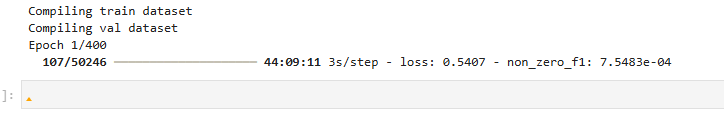

In [ ]:
max_time_seconds = 3600*12  # 1 hour is 3600 seconds
batch_size = 28
epochs = 400  # Set high enough to allow stopping by callback
steps_per_epoch = 7178

# print('Compiling train dataset')
# train_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/train.tfrecord.gz",
#                                 batch_size=batch_size, 
#                                 compression_type='GZIP', 
#                                 shuffled=True,
#                                 shuffle_buffer=10000,
#                                 total_records=200985,
#                                 num_to_drop=1 # Batch size 28 leaves remainder of 1 record
#                                 )
# train_dataset = train_dataset.repeat()

print('Compiling val dataset')
val_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/val.tfrecord.gz",
                                batch_size=batch_size, 
                                compression_type='GZIP', 
                                shuffled=False,
                                shuffle_buffer=5000,
                                total_records=23645,
                                num_to_drop=13, # Batch size 28 leaves remainder of 13 records
                                seed=42 # Seed for dropping the same 13 records every time
                                )
# val_dataset = val_dataset.repeat()
# test_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/test.tfrecord.gz",
#                                 batch_size=batch_size, 
#                                 compression_type='GZIP', 
#                                 shuffled=False,
#                                 shuffle_buffer=5000,
#                                 total_records=11824,
#                                 num_to_drop=8, # Batch size 28 leaves remainder of 13 records
#                                 seed=42 # Seed for dropping the same 8 records every time
#                                 )

# history = dcnn_model.fit(
#         train_dataset, 
#         validation_data=val_dataset,
#         # batch_size=batch_size,
#         epochs=epochs,
#         steps_per_epoch=steps_per_epoch,
#         callbacks=[early_stopping_cb, checkpoint_cb, CleanupCallback(), TimeLimit(max_time_seconds=max_time_seconds)]
#         )

# print('Saving model...')
# dcnn_model.save("Finished_Model.keras")
# # upload_file("Finished_Model.keras", s3_bucket, "checkpoints/Finished_Model.keras)
# print(f"📁 Model saved!")


loss_fn = CustomBinaryCrossentropyLoss(
    dominant_class_index=0,
    dominant_correct_multiplier=0.07,
    dominant_incorrect_multiplier=2.5,
    other_class_multiplier=2.0,
    smoothing_multiplier=0.5
)

# Define your checkpoint directory
checkpoint_dir = models_path + "checkpoints"

# Store results in a list
results_list = []

# Loop through all saved model files
for filename in sorted(os.listdir(checkpoint_dir)):  # Ensure sorted order
    if filename.endswith(".keras"):  # Adjust if using TensorFlow checkpoints
        model_path = os.path.join(checkpoint_dir, filename)
        print(f"Evaluating {filename}...")

        # Load the model (Include custom loss/metrics if necessary)
        model = models.load_model(model_path) 
        model.compile(
                    loss=loss_fn,
                    metrics=[
                        CustomNoBackgroundF1Score(num_classes=5, average='weighted', threshold=0.5),
                        CustomNoBackgroundF1Score(num_classes=5, average='macro', threshold=0.5),
                        CustomBackgroundOnlyF1Score(num_classes=5, average='weighted', threshold=0.5),
                        CustomBackgroundOnlyF1Score(num_classes=5, average='macro', threshold=0.5)
                        ]
                    )
            

        # Evaluate on validation dataset
        results = model.evaluate(val_dataset, verbose=1)  # Suppress output

        # Store results (Modify column names as needed)
        results_list.append({"Checkpoint": filename, "Results" : results})

# Convert results to a DataFrame
df_results = pd.DataFrame(results_list)

# Display the DataFrame
print(df_results)

# Save the DataFrame to a CSV file for later analysis
df_results.to_csv(models_path + "Results/validation_results.csv", index=False)

print("Validation results saved to 'Results/validation_results.csv'.")

Compiling val dataset
Evaluating epoch-001-val_loss-0.0263.keras...
844/844 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - background_only_f1: 0.9988 - background_only_f1_1: 0.9988 - loss: 0.0265 - no_background_f1: 0.4207 - no_background_f1_1: 0.4303
Evaluating epoch-003-val_loss-0.0247.keras...


2025-02-13 17:10:57.932497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2002610089650243901
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - background_only_f1: 0.9988 - background_only_f1_1: 0.9988 - loss: 0.0249 - no_background_f1: 0.3717 - no_background_f1_1: 0.3765
Evaluating epoch-004-val_loss-0.0244.keras...


2025-02-13 17:11:35.074019: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - background_only_f1: 0.9989 - background_only_f1_1: 0.9989 - loss: 0.0245 - no_background_f1: 0.5163 - no_background_f1_1: 0.5209
Evaluating epoch-005-val_loss-0.0243.keras...
844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - background_only_f1: 0.9988 - background_only_f1_1: 0.9988 - loss: 0.0244 - no_background_f1: 0.5009 - no_background_f1_1: 0.5118
Evaluating epoch-006-val_loss-0.0241.keras...


2025-02-13 17:12:49.209096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2002610089650243901
2025-02-13 17:12:49.209184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2528053032855672444


844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - background_only_f1: 0.9988 - background_only_f1_1: 0.9988 - loss: 0.0243 - no_background_f1: 0.4140 - no_background_f1_1: 0.4236
Evaluating epoch-007-val_loss-0.0240.keras...
844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - background_only_f1: 0.9987 - background_only_f1_1: 0.9987 - loss: 0.0242 - no_background_f1: 0.4610 - no_background_f1_1: 0.4702
Evaluating epoch-008-val_loss-0.0241.keras...


2025-02-13 17:14:04.028875: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 43ms/step - background_only_f1: 0.9988 - background_only_f1_1: 0.9988 - loss: 0.0242 - no_background_f1: 0.4353 - no_background_f1_1: 0.4431
Evaluating epoch-009-val_loss-0.0240.keras...


2025-02-13 17:14:41.839994: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2002610089650243901


844/844 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - background_only_f1: 0.9987 - background_only_f1_1: 0.9987 - loss: 0.0241 - no_background_f1: 0.4750 - no_background_f1_1: 0.4860
Evaluating epoch-010-val_loss-0.0240.keras...


2025-02-13 17:15:20.586088: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2002610089650243901
2025-02-13 17:15:20.586155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2528053032855672444


844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - background_only_f1: 0.9987 - background_only_f1_1: 0.9987 - loss: 0.0241 - no_background_f1: 0.4531 - no_background_f1_1: 0.4645
Evaluating epoch-011-val_loss-0.0243.keras...
844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - background_only_f1: 0.9989 - background_only_f1_1: 0.9989 - loss: 0.0244 - no_background_f1: 0.5004 - no_background_f1_1: 0.5101
Evaluating epoch-012-val_loss-0.0240.keras...
843/843 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - background_only_f1: 0.9988 - background_only_f1_1: 0.9988 - loss: 0.0241 - no_background_f1: 0.4848 - no_background_f1_1: 0.4919
Evaluating epoch-013-val_loss-0.0240.keras...
844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - background_only_f1: 0.9987 - background_only_f1_1: 0.9987 - loss: 0.0241 - no_background_f1: 0.4946 - no_background_f1_1: 0.5057
Evaluating epoch-016-val_loss-0.0240.keras...


2025-02-13 17:17:51.126163: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2528053032855672444


844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 43ms/step - background_only_f1: 0.9987 - background_only_f1_1: 0.9987 - loss: 0.0241 - no_background_f1: 0.4760 - no_background_f1_1: 0.4899
                         Checkpoint  \
0   epoch-001-val_loss-0.0263.keras   
1   epoch-003-val_loss-0.0247.keras   
2   epoch-004-val_loss-0.0244.keras   
3   epoch-005-val_loss-0.0243.keras   
4   epoch-006-val_loss-0.0241.keras   
5   epoch-007-val_loss-0.0240.keras   
6   epoch-008-val_loss-0.0241.keras   
7   epoch-009-val_loss-0.0240.keras   
8   epoch-010-val_loss-0.0240.keras   
9   epoch-011-val_loss-0.0243.keras   
10  epoch-012-val_loss-0.0240.keras   
11  epoch-013-val_loss-0.0240.keras   
12  epoch-016-val_loss-0.0240.keras   

                                              Results  
0   [0.02629547193646431, 0.4233812093734741, 0.42...  
1   [0.02472471073269844, 0.37515681982040405, 0.3...  
2   [0.02436007373034954, 0.518424928188324, 0.518...  
3   [0.024295059964060783, 0.5021491050720215, 0.5...  

2025-02-13 17:18:29.160182: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2002610089650243901
2025-02-13 17:18:29.160245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2528053032855672444


In [77]:
print(results_list)

[{'Checkpoint': 'epoch-001-val_loss-0.0263.keras', 'Results': [0.02629547193646431, 0.4233812093734741, 0.4233812093734741, 0.9988483190536499, 0.9988483190536499, 0.9988483190536499, 0.4332113564014435]}, {'Checkpoint': 'epoch-003-val_loss-0.0247.keras', 'Results': [0.02472471073269844, 0.37515681982040405, 0.37515681982040405, 0.9988055229187012, 0.9988055229187012, 0.9988055229187012, 0.3802448809146881]}, {'Checkpoint': 'epoch-004-val_loss-0.0244.keras', 'Results': [0.02436007373034954, 0.518424928188324, 0.518424928188324, 0.9988994598388672, 0.9988994598388672, 0.9988994002342224, 0.5233819484710693]}, {'Checkpoint': 'epoch-005-val_loss-0.0243.keras', 'Results': [0.024295059964060783, 0.5021491050720215, 0.5021491050720215, 0.9988505244255066, 0.9988505244255066, 0.9988505244255066, 0.5132834911346436]}, {'Checkpoint': 'epoch-006-val_loss-0.0241.keras', 'Results': [0.024132538586854935, 0.41637763381004333, 0.41637763381004333, 0.9988260269165039, 0.9988260269165039, 0.9988260269

In [ ]:
# # Define your checkpoint directory and file pattern.
# checkpoint_dir = models_path + "checkpoints"
# # Assume your checkpoint files follow the pattern 'cp-XXXX.ckpt'
# checkpoint_pattern = os.path.join(checkpoint_dir, "epoch-*-val_loss-*.keras")

# # Find the most recent checkpoint file.
# checkpoint_files = glob.glob(checkpoint_pattern)
# if checkpoint_files:
#     latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
#     print("Resuming from checkpoint:", latest_checkpoint)
    
#     # Load the entire model from the checkpoint.
#     dcnn_model = models.load_model(latest_checkpoint)
#     dcnn_model.compile()
    
#     epoch_str = os.path.basename(latest_checkpoint).split('-')[1]
#     # Remove any file extension; adjust the splitting as needed.
#     epoch_num = int(''.join(filter(str.isdigit, epoch_str)))
#     initial_epoch = epoch_num
# else:
#     print("No checkpoint found. Starting training from scratch.")
#     # Build and compile your model as you normally do.
#     dcnn_model = create_dcnn_model(5, 5000, 5)
#     dcnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.000686),
#                     loss=custom_binary_crossentropy_loss(
#                         dominant_class_index=0,
#                         dominant_correct_multiplier=0.07,
#                         dominant_incorrect_multiplier=2.5,
#                         other_class_multiplier=2.0,
#                         smoothing_multiplier=0.5
#                     ),
#                     metrics=[
#                         CustomNoBackgroundF1Score(num_classes=5, average='weighted', threshold=0.5),
#                         CustomNoBackgroundF1Score(num_classes=5, average='macro', threshold=0.5),
#                         CustomBackgroundOnlyF1Score(num_classes=5, average='weighted', threshold=0.5),
#                         CustomBackgroundOnlyF1Score(num_classes=5, average='macro', threshold=0.5)
#                         ]
#                     )
#     dcnn_model.summary()
#     initial_epoch = 0

# # Continue training.
# history = dcnn_model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     steps_per_epoch=steps_per_epoch,
#     callbacks=[early_stopping_cb, checkpoint_cb, CleanupCallback(), TimeLimit(max_time_seconds=max_time_seconds)],
#     initial_epoch=initial_epoch  # This tells Keras to start counting epochs from here.
# )

# # Save final model if needed.
# dcnn_model.save("Finished_Model.keras")
# print("📁 Model saved!")


In [79]:
dcnn_model.summarize()

AttributeError: 'Functional' object has no attribute 'summarize'